# 문자를 읽을 수 있는 딥러닝 

목차

- Import   

1. 데이터 준비 

2. keras-ocr, Tesseract

3. Summary

## Import

In [1]:
!pip install --upgrade matplotlib
!sudo apt install tesseract-ocr
!pip install google-cloud-vision keras_ocr pytesseract easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

## 데이터 준비

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
work_dir = '/content/drive/MyDrive/Colab Notebooks/test_image/'

images = glob(work_dir+'*.jpg')
images.sort()
images

['/content/drive/MyDrive/Colab Notebooks/test_image/sign1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/test_image/sign2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/test_image/wise1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/test_image/wise2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/test_image/wise3.jpg']

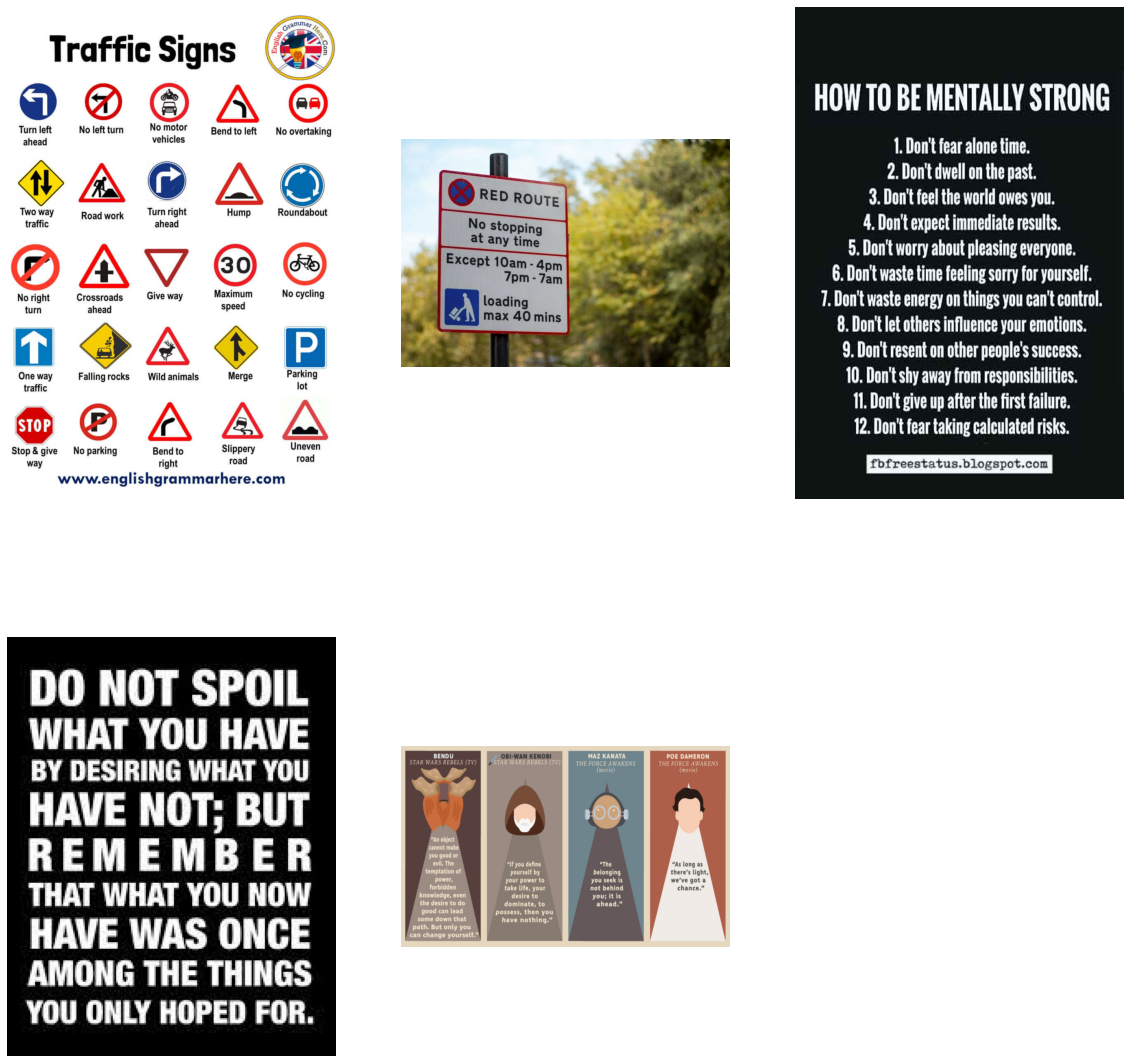

In [6]:
plt.figure(figsize=(20,20))

for idx, im in enumerate(images):
    plt.subplot(2, 3, idx+1)
    im = img.imread(im)
    plt.imshow(im)
    plt.axis('off')

## Keras

In [7]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [8]:
images_keras_ocr = [ keras_ocr.tools.read(im) for im in images]
prediction_groups = [pipeline.recognize([im]) for im in images]

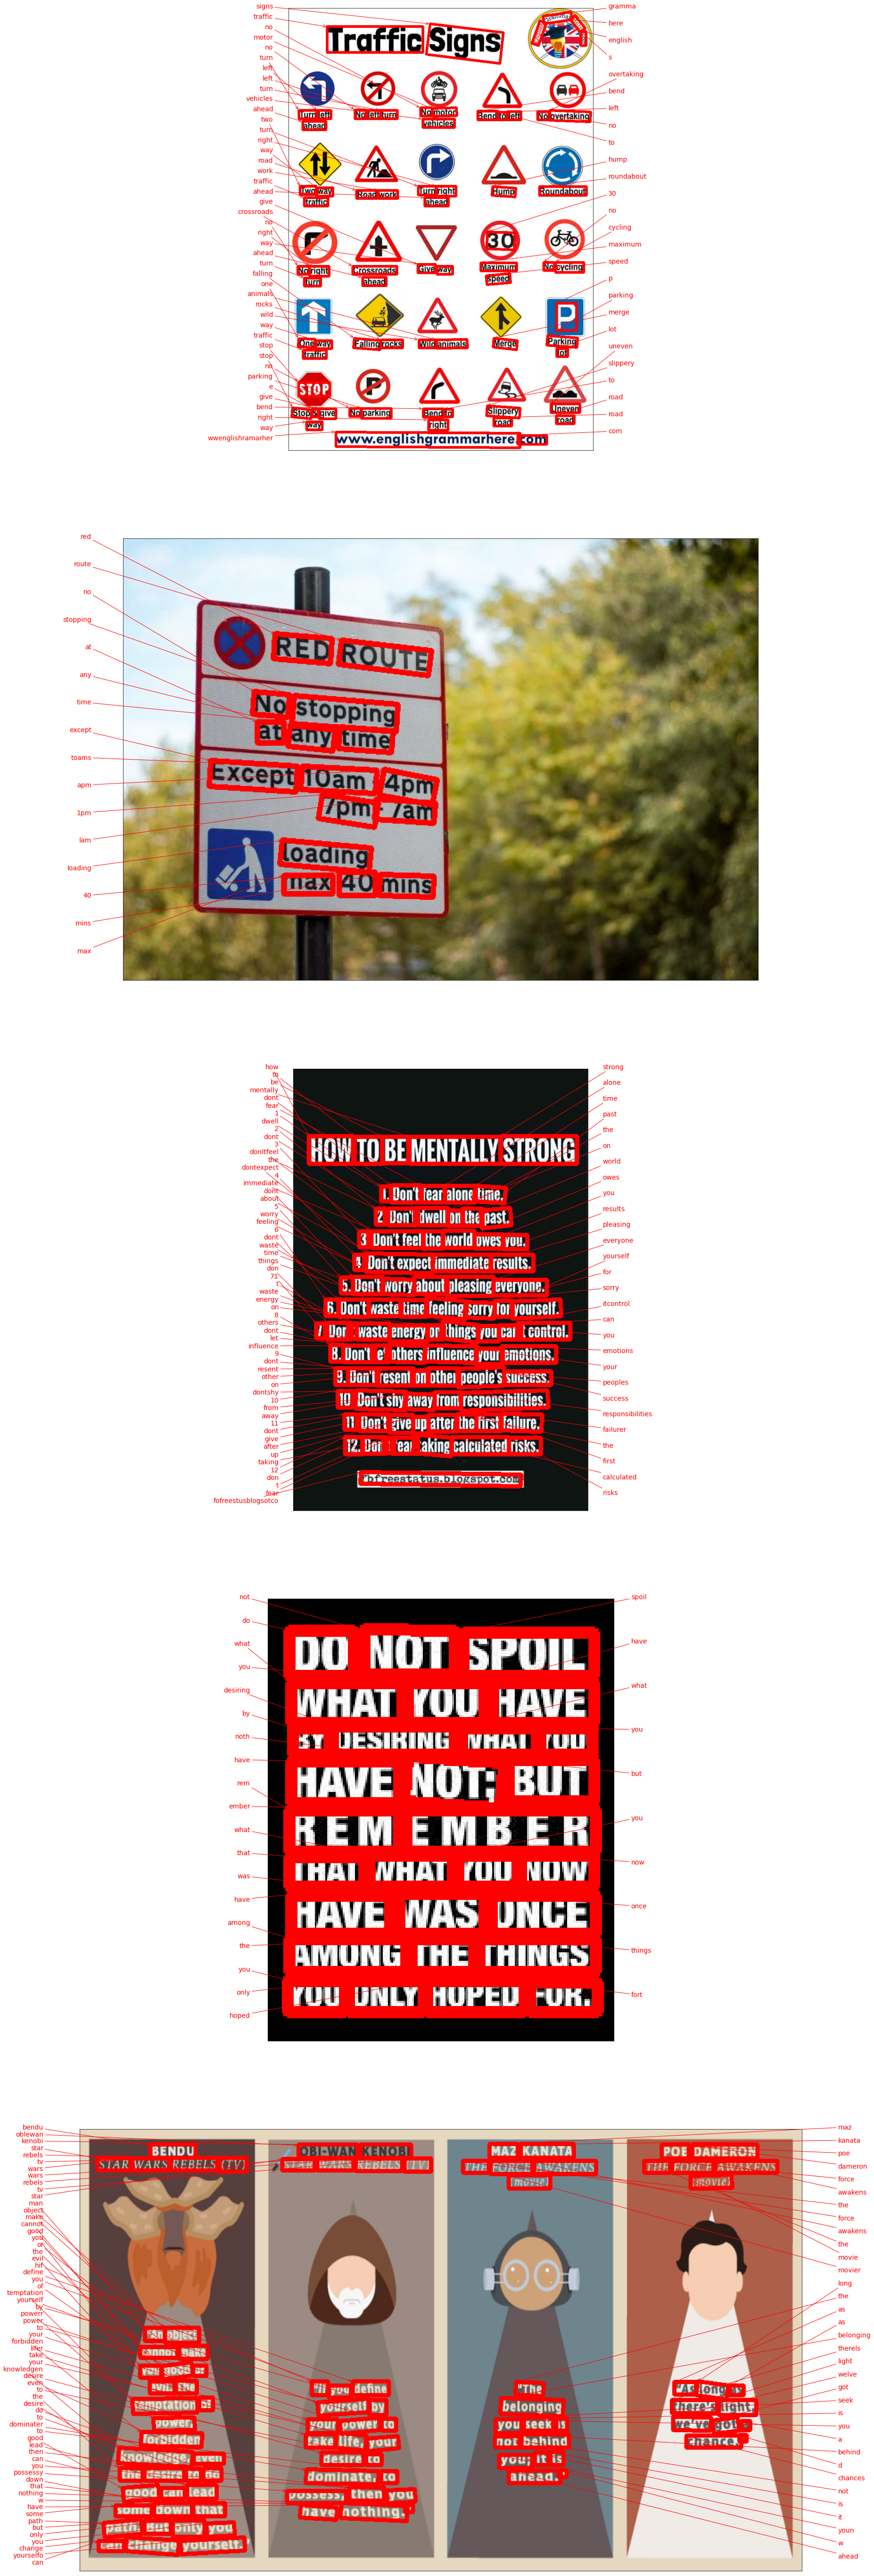

In [9]:
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract

In [15]:
def crop_word_regions(idx, image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [18]:
cropped_image_path_list = []
for idx, img_path in enumerate(images):
    cropped_image_path_list.append(crop_word_regions(idx, img_path, f"{work_dir}/tesseract/{idx}"))

In [19]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result += " ".join(recognized_data['text'].split()) + " "
    print(result)
    print("------------------------------Done------------------------------")
    print()

In [20]:
for cr_path in cropped_image_path_list:
    recognize_images(cr_path)

Traffic Signs @) A \  Turn left N 9 left turn No motor  Bend to left NO overtaking anead vehicles Two Way Road WOrk Turn right nump Roundabout traffic ahead N o right Crossroads Give Way Viaximum N oO cycling turn ahead speed One Wady Falling rocks Wild animals Vierge Parking traffic lot Stop & give NO parking Bend tO Slippery Uneven Way right roaqd road www.englishgrammarhere.com 
------------------------------Done------------------------------

No Stopping at any time Except 10am - 4pm 7pm ae Jam loading max 40 mins a) | 
------------------------------Done------------------------------

Ta F MENTALLY STRONG mina: ATA RAT ed z ont iwell uy the ENS 3. Win faa the TTT ALL Wites LUI mga! ect | mmediate res Ty Sm ATT nleasing everyone.  With  lime (al thu SUITY i NTR HL Piha ry BY WUT Ts TAU CP a Win ti NUTR influence i ATU SS I ont Tayi |! WY Nua ay as SITHRAY vt ont 1  RCL responsibilities. We ont YT UL “VC the nirst  17 Dont fearta king calculated risks. (oireestatus.ologspot.com 
----

##Summary  


-  keras-ocr과 Tesseract로 OCR을 진행했다.
- 결과적으로, Tesseract는 keras-ocr에 비해 기능이 매우 떨어지는 것으로 확인된다.
- 주목할만한 점은, keras-ocr가 높은 인식률을 보여줬지만, 제대로 인식하지 못한 몇몇 글자들이 존재하는데, 특히 줄글 형식의 문자가 빼곡할 경우 몇몇 알파벳을 인식하지 못하는 것으로 보인다. ex) www.englishgrammarhere.com 그러나, 이 글자들을 Tesseract에서는 인식했는데, 이를 말미암아 보았을 때, Tesseract는 책 스캔본 같은 것을 읽는데에 적용하면 좋을듯?
- 사진이 몇개 더 있었는데, 출력하는 과정에서 오류가 자꾸 나서 빼버렸다. 지나고 보니 아마 기울어진 글자가 있는데, 그걸 찾으려면 Tesseract에서는 좌표값을 새로 넣어줘야할 듯